# Multiple Grid Cells in MUSICA
In MUSICA, the State object that is present within the Solver object has an attribute called <i>number_of_grid_cells</i>.</br>
This attribute dictates the number of independent sets of well-mixed air masses that will be solved by solver.</br>
This tutorial will go over a simple example of running a multi-grid-cell solver in MUSICA.

## 1. Importing Libraries
Below is a list of the required libraries for this tutorial:

In [1]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
from scipy.stats import qmc
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Defining a System

This code snippet is a MUSICA version of setting up a system, which has an identical workflow to MusicBox.</br>
For an explanation of this code in MusicBox, please refer to the Basic Workflow Jupyter Notebook.

In [2]:
A = mc.Species(name="A")
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C]
gas = mc.Phase(name="gas", species=species)

r1 = mc.Arrhenius(
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2]
)

## 3. Creating the Solver
Something more unique to MUSICA is that you have to manually define the solver.</br>
There are a handful of solvers available, but Rosenbrock Standard Order will be used here.</br>
For more information on the types of solvers available, go [here](https://ncar.github.io/musica/api/python.html#musica.types.SolverType).

In [3]:
solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

## 4. Creating the State
For MUSICA, the state must be created manually as well, with the number of grid cells being passed into the <i>create_state()</i> function.</br>
Feel free to change the <i>num_grid_cells</i> value to experiment yourself.

In [4]:
num_grid_cells = 100
state = solver.create_state(num_grid_cells)

## 5. Populating the Grid Cells
5 dimensions will be used to populate the data for each of the air masses:
* temperature (Kelvin),
* pressure (Pascals), and
* the concentrations of each of the species (mol/m<sup>3</sup>).

For the sake of simplicity, the values used are repeated across every grid cell, hence the use of NumPy's <i>repeat()</i> function.</br>
The resulting array is displayed so that you can visualize what the functions did to the data.

In [5]:
box_model_values = [[300, 101253.3, 5, 5, 5]]
box_model_values = np.repeat(box_model_values, num_grid_cells, axis = 0)
display(box_model_values)

array([[   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. ],
       [   300. , 101253.3,      5. ,      5. ,      5. 

## 6. Splitting up the Array Output
Next, the values from the <i>box_model_values</i> array are taken and populated into variables so that they can be passed into the solver's state.</br>
The sample is organized into 5 columns that contain the 5 variables.</br>
These columns are populated into their respective variables and then passed into the solver's state.</br>
Lastly, an empty array is initialized to represent the solved concentration array at every time step, as well as the time step length, simulation length, and the current time step (all in seconds).

In [6]:
temperatures = box_model_values[:, 0]
pressures = box_model_values[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = box_model_values[:, 2]
concentrations["B"] = box_model_values[:, 3]
concentrations["C"] = box_model_values[:, 4]

state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 100
curr_time = 1

## 7. Defining the Solver Function
This code first appends the initial conditions to the solved array to represent the first time step at t = 0 secs.</br>
The system is then solved at every specified time step and the solved concentrations are appended to the array.

In [7]:
def solver_func(state, concentrations_solved, solver, curr_time):
    concentrations_solved.append(state.get_concentrations()) # Add initial conditions as the first time step
    while curr_time <= sim_length:
        solver.solve(state, curr_time)
        concentrations_solved.append(state.get_concentrations())
        curr_time += time_step_length

## 8. Calling the Solver Function and Preparing the Results
Here, the defined <i>solver_func</i> is called to populated the <i>concentrations_solved</i> array of dictionaries.</br>
Once that is done, a new array is made that grabs only the first value (grid cell) for each key (species) at every time step.</br>
The time step index is divided by the time_step_length to account for time step lengths that are greater than one for proper array indexing.</br>
That new array is then passed into a Pandas DataFrame with the concentration columns renamed.</br>
Next, a time column is created from a range that represents the elapsed time at each time step.</br>
In this simulation, the temperature, pressure, and air density are all constant, so numpy's <i>repeat()</i> function is used to repeat their respective values for every time step.</br>
Once all the attributes are added to the DataFrame, their order is changed to follow a more logical flow.

In [8]:
solver_func(state, concentrations_solved, solver, curr_time)
concentrations_solved_pd = []
for i in range(0, sim_length + 1, time_step_length):
    concentrations_solved_pd.append({key: value[0] for key, value in concentrations_solved[int(i/time_step_length)].items()})
df = pd.DataFrame(concentrations_solved_pd)
df = df.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df['time.s'] = list(map(float, range(0, sim_length + 1, time_step_length)))
df['ENV.temperature.K'] = np.repeat(temperatures[0], sim_length/time_step_length + 1.0)
df['ENV.pressure.Pa'] = np.repeat(pressures[0], sim_length/time_step_length + 1.0)
df['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], sim_length/time_step_length + 1.0)
df = df[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]

## 9. Viewing the Results
With the DataFrame being fully prepared now, it is displayed and plotted to show the evolution of one of the systems over time.

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0.0,300.0,101253.3,40.59324282282551,5.0,5.0,5.0
1,1.0,300.0,101253.3,40.59324282282551,4.976428528398802,4.999944351093875,5.0236271205073235
2,2.0,300.0,101253.3,40.59324282282551,4.929618429433882,4.999502304184354,5.070879266381759
3,3.0,300.0,101253.3,40.59324282282551,4.860227571898497,4.998027906909858,5.141744521191641
4,4.0,300.0,101253.3,40.59324282282551,4.769223461910271,4.994590343685047,5.236186194404681
...,...,...,...,...,...,...,...
96,96.0,300.0,101253.3,40.59324282282551,1.3848930638088484e-09,3.188394436729693e-08,14.999999966731156
97,97.0,300.0,101253.3,40.59324282282551,8.755544769574368e-10,2.055945154890085e-08,14.99999997856499
98,98.0,300.0,101253.3,40.59324282282551,5.509314339190389e-10,1.3192231875586652e-08,14.999999986256833
99,99.0,300.0,101253.3,40.59324282282551,3.4503197053012484e-10,8.423521284442348e-09,14.999999991231443


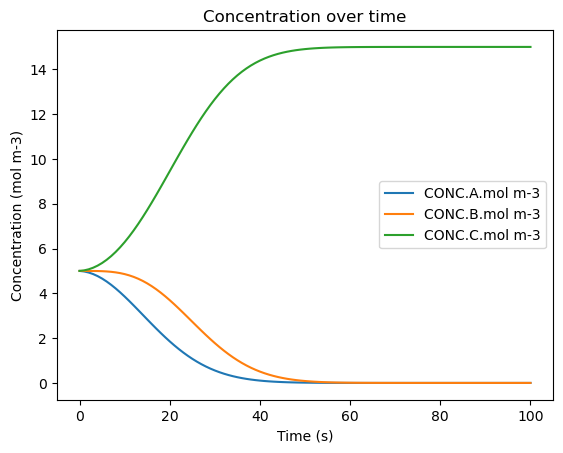

In [9]:
display(df)
df.plot(x='time.s', y=['CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3'], title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
plt.show()

# Latin Hypercube Sampling in MUSICA
Latin Hypercube Sampling (LHS) is a statistical method for generating multidimensional random samples.</br>
It avoids the problem of clustering that can sometimes appear in pure random sampling.</br>
This tutorial will go over a simple example of utilizing LHS to run a multi-grid-cell solver in MUSICA.</br>

## 1. Rerunning Previous Code
This is simply a copy of the first 4 steps from the above multiple grid cells tutorial since the code is identical up to this point.

In [10]:
A = mc.Species(name="A")
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C]
gas = mc.Phase(name="gas", species=species)

r1 = mc.Arrhenius(
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism(
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2]
)

solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

num_grid_cells = 100
state = solver.create_state(num_grid_cells)

## 2. Creating and Scaling a Latin Hypercube Sampler
This Latin Hypercube Sampler uses the same 5 dimensions as the previous tutorial to randomize each of the individual systems, being:
* temperature (Kelvin),
* pressure (Pascals), and
* the concentrations of each of the species (mol/m<sup>3</sup>).

Next, the LHS is created with the provided number of dimensions with a randomized sample that will be scaled by the sampler.</br>
The upper and lower bounds for each of the five dimensions are then set, and the sample is scaled with those bounds by the LHS.

In [11]:
ndim = 5
nsamples = num_grid_cells

# Create a Latin Hypercube sampler in the unit hypercube
sampler = qmc.LatinHypercube(d=ndim)

# Generate samples
sample = sampler.random(n=nsamples)

# Define bounds for each dimension
l_bounds = [275, 100753.3, 0, 0, 0] # Lower bounds
u_bounds = [325, 101753.3, 10, 10, 10] # Upper bounds

# Scale the samples to the defined bounds
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

## 3. Rerunning Previous Code
This is a copy of the previous tutorial's code after the LHS since almost nothing changes until the visualization section.</br>
The only difference of note is changing the old <i>box_model_values</i> array to the new <i>sample_scaled</i> output array from the LHS.

In [12]:
temperatures = sample_scaled[:, 0]
pressures = sample_scaled[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = sample_scaled[:, 2]
concentrations["B"] = sample_scaled[:, 3]
concentrations["C"] = sample_scaled[:, 4]

state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 100
curr_time = 1

def solver_func(state, concentrations_solved, solver, curr_time):
    concentrations_solved.append(state.get_concentrations()) # Add initial conditions as the first time step
    while curr_time <= sim_length:
        solver.solve(state, curr_time)
        concentrations_solved.append(state.get_concentrations())
        curr_time += time_step_length

solver_func(state, concentrations_solved, solver, curr_time)
concentrations_solved_pd = []
for i in range(0, sim_length + 1, time_step_length):
    concentrations_solved_pd.append({key: value[0] for key, value in concentrations_solved[int(i/time_step_length)].items()})
df = pd.DataFrame(concentrations_solved_pd)
df = df.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df['time.s'] = list(map(float, range(0, sim_length + 1, time_step_length)))
df['ENV.temperature.K'] = np.repeat(temperatures[0], sim_length/time_step_length + 1.0)
df['ENV.pressure.Pa'] = np.repeat(pressures[0], sim_length/time_step_length + 1.0)
df['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], sim_length/time_step_length + 1.0)
df = df[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
display(df)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0.0,309.78338149363844,101543.77643542801,39.42402937477069,3.682284068605181,5.189847361451441,8.232724658048902
1,1.0,309.78338149363844,101543.77643542801,39.42402937477069,3.6650156157624467,5.182736932600102,8.257103539742973
2,2.0,309.78338149363844,101543.77643542801,39.42402937477069,3.630721276569198,5.168374336376142,8.305760475160179
3,3.0,309.78338149363844,101543.77643542801,39.42402937477069,3.5798805150181336,5.146485045328571,8.378490527758816
4,4.0,309.78338149363844,101543.77643542801,39.42402937477069,3.513198536452761,5.116679174625489,8.474978377027266
...,...,...,...,...,...,...,...
96,96.0,309.78338149363844,101543.77643542801,39.42402937477069,1.1449152016456725e-09,2.669502749126976e-08,17.104856060265632
97,97.0,309.78338149363844,101543.77643542801,39.42402937477069,7.255822352343744e-10,1.724905104014427e-08,17.10485607013094
98,98.0,309.78338149363844,101543.77643542801,39.42402937477069,4.576760504141316e-10,1.1091297770220084e-08,17.104856076556583
99,99.0,309.78338149363844,101543.77643542801,39.42402937477069,2.8733459694094004e-10,7.097135077178593e-09,17.10485608072109


## 4. Expanding out the DataFrame
The intention of this code snippet is to split up each grid cell for each time step onto a separate row in the DataFrame so they can be averaged when plotted.</br>
This will produce a confidence interval for each time step since there will be a set of unique values at every time step for each species.</br>
As an example, if there are 2 grid cells and 5 time steps, the data table will have 10 rows, with the first being the first grid cell for the first time step, the second row being the second grid cell for the first time step, the third row being the first grid cell for the second time step, and so on.</br>
You can see this pattern in the displayed DataFrame as well.</br>
After the expansion of the DataFrame, adding the other columns is fairly similar; they are simply given more rows since the number of rows is now the product of the number of grid cells and the number of time steps.</br>
The time column is notably different, however, since each time step has to be repeated for every grid cell.</br>
Once that is all done, the expanded DataFrame is displayed. Note that the first column is the index of the DataFrame, not the time step here.

In [13]:
concentrations_solved_expanded = []
time = []
for i in range(0, sim_length + 1, time_step_length):
    for j in range(0, num_grid_cells):
        concentrations_solved_expanded.append({key: value[j] for key, value in concentrations_solved[int(i/time_step_length)].items()})
        time.append(i)
df_expanded = pd.DataFrame(concentrations_solved_expanded)
df_expanded = df_expanded.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
df_expanded['time.s'] = time
df_expanded['ENV.temperature.K'] = np.repeat(temperatures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.pressure.Pa'] = np.repeat(pressures[0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][0], (sim_length/time_step_length + 1.0) * num_grid_cells)
df_expanded = df_expanded[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
display(df_expanded)

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0,309.78338149363844,101543.77643542801,39.42402937477069,3.682284068605181,5.189847361451441,8.232724658048902
1,0,309.78338149363844,101543.77643542801,39.42402937477069,5.096845736976592,7.627884156099922,7.755704074280443
2,0,309.78338149363844,101543.77643542801,39.42402937477069,8.047059295729579,1.800810512897043,3.1521303116276513
3,0,309.78338149363844,101543.77643542801,39.42402937477069,6.82758621108575,6.395686755662961,2.992571907848492
4,0,309.78338149363844,101543.77643542801,39.42402937477069,8.36348064183748,5.444168463251003,2.5704255964858658
...,...,...,...,...,...,...,...
10095,100,309.78338149363844,101543.77643542801,39.42402937477069,9.845808746366072e-12,2.882668010602939e-10,1.8484674768622245
10096,100,309.78338149363844,101543.77643542801,39.42402937477069,7.087406982477918e-11,1.9636321793712178e-09,9.173684129940602
10097,100,309.78338149363844,101543.77643542801,39.42402937477069,2.7535987828509794e-10,6.9122126355250565e-09,12.816928273762235
10098,100,309.78338149363844,101543.77643542801,39.42402937477069,1.7562622112762792e-10,4.327778790968643e-09,8.449758225729914


## 5. Visualizing the Results
Lastly, the three species are plotted out with Seaborn's <i>lineplot()</i> function, which takes in an input x and y variable with the confidence interval (CI) displayed.</br>
There are additional parameters passed in as well, such as setting the alpha so that the CI is more visible.</br>
Since the DataFrame has more than one value for each time step (x-axis), the solid line represents the mean of the species' concentrations at every time step.

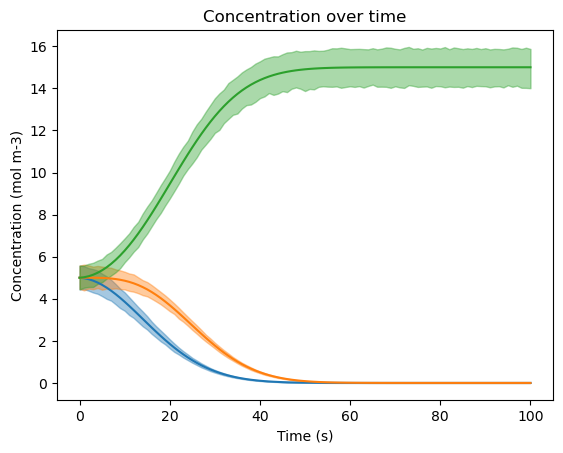

In [14]:
sns.lineplot(data=df_expanded, x='time.s', y='CONC.A.mol m-3', errorbar='ci', err_kws={'alpha' : 0.4}).set(title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.B.mol m-3', errorbar='ci', err_kws={'alpha' : 0.4}).set(title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
sns.lineplot(data=df_expanded, x='time.s', y='CONC.C.mol m-3', errorbar='ci', err_kws={'alpha' : 0.4}).set(title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
plt.show()